# スリザーリンク

[スリザーリンク（Slitherlink）](https://ja.puzzle-loop.com/)は、方眼状の盤面に配置された数字をヒントにして、線を引いて一つの閉じたループを作るパズルです。以下に基本ルールを説明します。

`````{admonition} スリザーリンクパズルのサイト
:class: tip
https://ja.puzzle-loop.com

`helper.puzzle.extract_slither_link()` を使うと、このサイトのパズル盤面を取得できます。ブラウザの開発者ツールを開き、盤面を表す `<div>` タグのコードをコピーし、この関数を実行すると、盤面が配列として取得できます。  
`````

![](https://www.nikoli.co.jp/en/wp-content/themes/nikoli_en/images/puzzles/slitherlink03.gif)

1. **線を引く**  
   ・盤面の点（格子点）を結ぶように、縦または横に線を引くことができます。  
   ・線は途中で途切れたり、交差したり、枝分かれしたりしてはいけません。  

2. **数字の意味**  
   ・マスに書かれた数字は、そのマスの周囲に引かれる線の本数を表します。  
   ・例えば「3」が書かれたマスの周囲には、必ず3本の線が引かれます。  
   ・「0」のマスの周囲には線を引いてはいけません。  
   ・数字が書かれていないマスは、線の本数に制限がありません。  

3. **閉じたループを作る**  
   ・すべての線はつながり、一つの閉じたループ（輪）を形成しなければなりません。  
   ・ループは枝分かれや交差をしてはいけません。  

盤面上の点を頂点とし、ループの横線または縦線を辺とすることで、スリザーリンクは回路を探索する問題となります。そのため、CP-SATの`add_circuit()`制約を使用して解くことができます。 また、すべての頂点を通る必要がないため、特定の頂点を除外できるように、すべての頂点に対して`(i, i, bool_var)`の辺を`add_circuit()`に追加します。

In [3]:
from ortools.sat.python import cp_model
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict

## 盤面の読み込みと描画  

次のコードで盤面を読み込み、描画します。

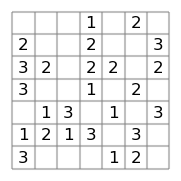

In [5]:
from matplotlib.collections import LineCollection

def plot_slither_link_board(board, result=None):
    h, w = board.shape    

    fig, ax = plt.subplots(figsize=(w*0.3, h*0.3))
    ax.set_ylim(-0.1, h + 0.1)
    ax.set_xlim(-0.1, w + 0.1)
    ax.invert_yaxis()
    ax.set_aspect("equal")
    all_segments = []
    circuit_segments = []

    if result is not None:
        for (n1, n2), flag in result.items():
            if flag:
                r1, c1 = n1 // (w + 1), n1 % (w + 1)
                r2, c2 = n2 // (w + 1), n2 % (w + 1)                
                circuit_segments.append([(c1, r1), (c2, r2)])

    for r, c in np.ndindex(h + 1, w + 1):
        if r + 1 <= h:
            all_segments.append([(c, r), (c, r + 1)])
        if c + 1 <= w:
            all_segments.append([(c, r), (c + 1, r)])

    ax.add_collection(LineCollection(all_segments, color='gray', alpha=0.5))
    ax.add_collection(LineCollection(circuit_segments, color='green', linewidth=2))
    for (i, j), v in np.ndenumerate(board):
        if v != -1:
            ax.text(j + 0.5, i + 0.5, str(v), fontsize=12, va='center', ha='center')
    ax.autoscale_view()        
    ax.axis('off')
    return fig, ax

board = np.loadtxt('data/slitherlink01.txt', dtype=np.int8)
plot_slither_link_board(board);

## 解くコード

次のコードは、スリザーリンクパズルを解くクラス `SlitherLinkSolver` を定義しています。

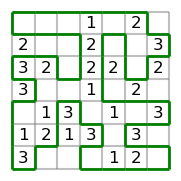

In [7]:
class SlitherLinkSolver:
    def __init__(self, board):
        self.board = board
        h, w = self.board.shape
        self.nodes = nodes = np.arange((h + 1) * (w + 1)).reshape(h + 1, w + 1)

        self.edges = edges = []
        for (r, c), s in np.ndenumerate(nodes):
            if c + 1 <= w:
                right = (r, c + 1)
                e = nodes[right]
                edges.extend([(s, e), (e, s)])
            if r + 1 <= h:
                below = (r + 1, c)
                e = nodes[below]
                edges.extend([(s, e), (e, s)])
        
        self.cell_edges = cell_edges = defaultdict(set)
        for (r, c), _ in np.ndenumerate(board):
            n1 = nodes[r, c]
            n2 = nodes[r, c + 1]
            n3 = nodes[r + 1, c]
            n4 = nodes[r + 1, c + 1]
            for edge in [(n1, n2), (n1, n3), (n2, n4), (n3, n4)]:
                cell_edges[r, c].add(edge)
                cell_edges[r, c].add(edge[::-1])
        
        model = cp_model.CpModel()
        variables = {e:model.new_bool_var(f'edge{e}') for e in edges}
        dummies = [(i, i, model.new_bool_var(f'dummy_{i}')) for i in range(0, (h + 1) * (w + 1))]
        model.add_circuit([(s, e, v) for (s, e), v in variables.items()] + dummies)
        
        for (r, c), count in np.ndenumerate(board):
            box_edges = [variables[edge] for edge in cell_edges[r, c]]
            if count != -1:
                model.add(sum(box_edges) == count)
        
        solver = cp_model.CpSolver()
        solver.solve(model)
        self.result = {key:solver.value(val) for key, val in variables.items()}

solver = SlitherLinkSolver(board)
plot_slither_link_board(board, solver.result);

## コードの説明

`h × w` の盤面の場合、`(h+1) × (w+1)` の格子点が存在します。各格子点を 1 次元の整数インデックスで管理し、形状 `(h+1, w+1)` の NumPy 配列 `nodes` に格納します。これにより、各ノードに固有の ID を割り当てることができます。

```python
self.nodes = nodes = np.arange((h + 1) * (w + 1)).reshape(h + 1, w + 1)
```

次に、各ノード `(r, c)` について、右 (`r, c+1`) および下 (`r+1, c`) に隣接するノードとの間に双方向の辺 `(s, e), (e, s)` を追加します。これにより、ループを形成するためのすべての候補となる線が `self.edges` に格納されます。

```python
self.edges = edges = []
for (r, c), s in np.ndenumerate(nodes):
    if c + 1 <= w:
        right = (r, c + 1)
        e = nodes[right]
        edges.extend([(s, e), (e, s)])
    if r + 1 <= h:
        below = (r + 1, c)
        e = nodes[below]
        edges.extend([(s, e), (e, s)])
```

次に、各セル `(r, c)` について、そのセルを構成する 4 本の辺（合計 8 つの有向辺）を `cell_edges[r, c]` に格納します。

```python
self.cell_edges = cell_edges = defaultdict(set)
for (r, c), _ in np.ndenumerate(board):
    n1 = nodes[r, c]
    n2 = nodes[r, c + 1]
    n3 = nodes[r + 1, c]
    n4 = nodes[r + 1, c + 1]
    for edge in [(n1, n2), (n1, n3), (n2, n4), (n3, n4)]:
        cell_edges[r, c].add(edge)
        cell_edges[r, c].add(edge[::-1])
```

各辺に対応するブール変数を作成します。

```python
model = cp_model.CpModel()
variables = {e: model.new_bool_var(f'edge{e}') for e in edges}
```

`add_circuit()` は回路制約を追加し、1 つの閉じたループを強制します。ただし、スリザーリンクではすべてのノードを通る必要がないため、`(i, i, bool_var)` の自己ループ（ダミー辺）を作成し、`add_circuit()` に追加します。この自己ループを利用することで、ループに含まれないノードを表現し、部分的な回路の除外を可能にします。

```python
dummies = [(i, i, model.new_bool_var(f'dummy_{i}')) for i in range((h + 1) * (w + 1))]
model.add_circuit([(s, e, v) for (s, e), v in variables.items()] + dummies)
```

最後に、セルごとの辺の制約を追加します。マスに書かれた数字 `count` が `-1` でない場合、そのマスの周囲の線の本数が `count` になるように制約を追加します。

```python
for (r, c), count in np.ndenumerate(board):
    box_edges = [variables[edge] for edge in cell_edges[r, c]]
    if count != -1:
        model.add(sum(box_edges) == count)
```

## 最も難しいパズル  

最後に、最も難しいパズルを解いてみます。

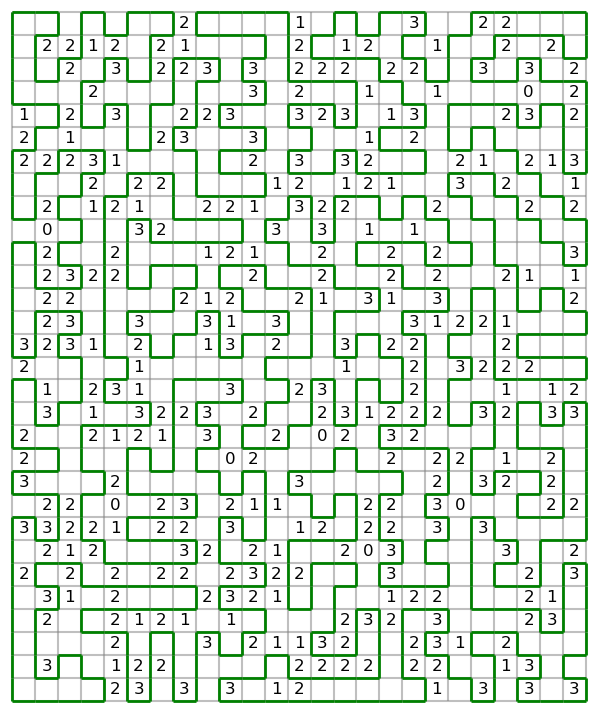

In [8]:
board = np.loadtxt('data/slitherlink02.txt', dtype=np.int8)
solver = SlitherLinkSolver(board)
plot_slither_link_board(board, solver.result);